In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sns.set()

In [2]:
categ = pd.read_csv("ravdess_categorical.csv")
quant = pd.read_csv("ravdess_quantitative.csv")

print(len(quant.columns))
display(categ.head())
display(quant.head())

18


,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F


,kur,length_ms,mean,mfcc_max,mfcc_mean,mfcc_std,sc_kur,sc_max,sc_mean,sc_min,sc_skew,sc_std,skew,stft_kur,stft_min,stft_skew,stft_std,zero_crossings_sum
0,9.406061,3737,3.844916e-07,0.295213,0.364634,0.454352,0.123738,0.599230,0.648163,0.575309,0.325936,0.551824,0.273153,0.184467,0.437367,0.568130,0.689802,16995
1,19.564187,3904,-7.149491e-08,0.511665,0.505299,0.417233,0.048477,0.442238,0.535794,0.428604,0.312511,0.766001,0.292157,0.115827,0.397277,0.522350,0.782470,13906
2,4.881241,4671,2.429985e-06,0.254710,0.468918,0.382435,0.122017,0.442998,0.466500,0.480660,0.405462,0.553049,0.302659,0.173137,0.290466,0.595302,0.781861,18723
3,13.040259,3637,2.373929e-07,0.414398,0.273763,0.677553,0.054609,0.447119,0.569571,0.451037,0.260804,0.769826,-0.081014,0.091015,0.316737,0.515785,0.827419,11617
4,7.485109,4404,8.454691e-07,0.226628,0.438075,0.342806,0.115161,0.444813,0.526047,0.494780,0.430878,0.586275,0.414872,0.122901,0.343053,0.533742,0.772979,15137


In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [4]:
from sklearn.cluster import KMeans

filter_used = (categ.vocal_channel != 'pipo')
used_quant = quant.loc[filter_used]
used_cat = categ.loc[filter_used]
n_means = 3

scaler = MinMaxScaler()
X = used_quant.values
X = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=n_means, n_init=20, max_iter=100)
kmeans.fit(X)


KMeans(max_iter=100, n_clusters=3, n_init=20)

In [5]:
centers = kmeans.cluster_centers_
# used_quant['kmeans_labels'] = kmeans.labels_;
print(kmeans.inertia_)

571.8914669427122


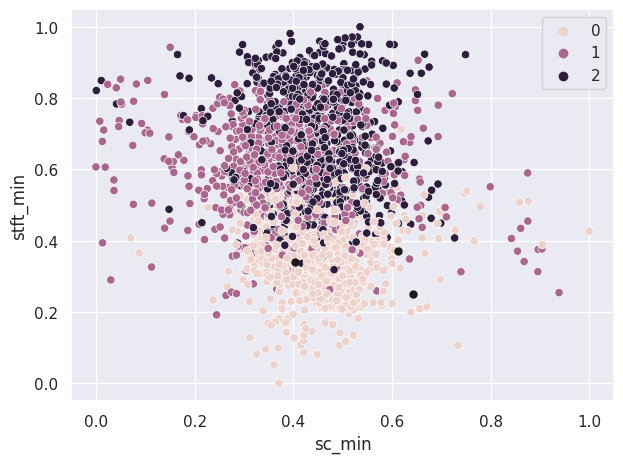

In [6]:
sns.scatterplot(data=used_quant, x="sc_min", y="stft_min", hue=kmeans.labels_)
plt.legend()
plt.scatter(centers[:,11], centers[:,17], marker='.', color="k", s=100)
plt.show()

<AxesSubplot: >

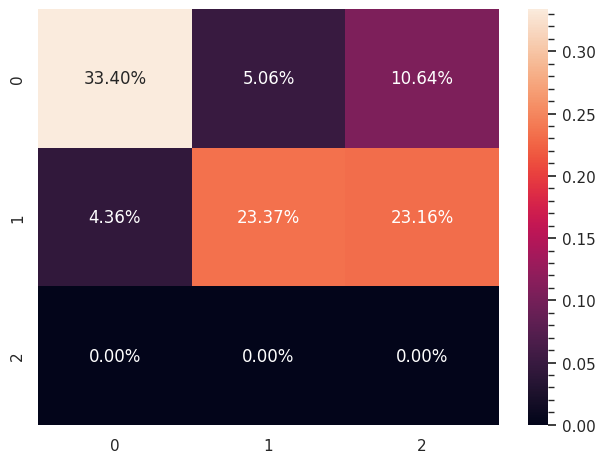

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

conf_m = confusion_matrix(pd.Categorical(used_cat.sex).codes, kmeans.labels_)
sns.heatmap(conf_m/np.sum(conf_m), annot = True, fmt='.2%')

In [8]:
import umap 

X = used_quant.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
reducer = umap.UMAP(n_neighbors=200)
embedding = reducer.fit_transform(X)

In [9]:
e_df = pd.DataFrame()
e_df["x"] = embedding[:,0]
e_df["y"] = embedding[:,1]
e_df["kmeans_label"] = kmeans.labels_
e_df = e_df.join(used_cat.reset_index())
display(e_df)

,x,y,kmeans_label,index,vocal_channel,emotion,emotional_intensity,statement,repetition,actor,sex
0,4.675941,9.854922,0,0,speech,fearful,normal,Dogs are sitting by the door,2nd,2.0,F
1,4.601022,10.484661,0,1,speech,angry,normal,Dogs are sitting by the door,1st,16.0,F
2,6.886137,9.050031,0,2,song,happy,strong,Dogs are sitting by the door,2nd,16.0,F
3,3.679919,11.819713,0,3,speech,surprised,normal,Kids are talking by the door,1st,14.0,F
4,6.543078,9.589133,0,4,song,happy,strong,Dogs are sitting by the door,2nd,2.0,F
...,...,...,...,...,...,...,...,...,...,...,...
2447,1.064824,10.273995,2,2447,speech,calm,strong,Kids are talking by the door,1st,23.0,M
2448,0.869238,10.614226,2,2448,speech,calm,normal,Dogs are sitting by the door,1st,23.0,M
2449,1.886369,5.535745,1,2449,song,sad,strong,Dogs are sitting by the door,2nd,23.0,M
2450,1.599621,9.263277,2,2450,speech,surprised,normal,Kids are talking by the door,1st,GNAA,M


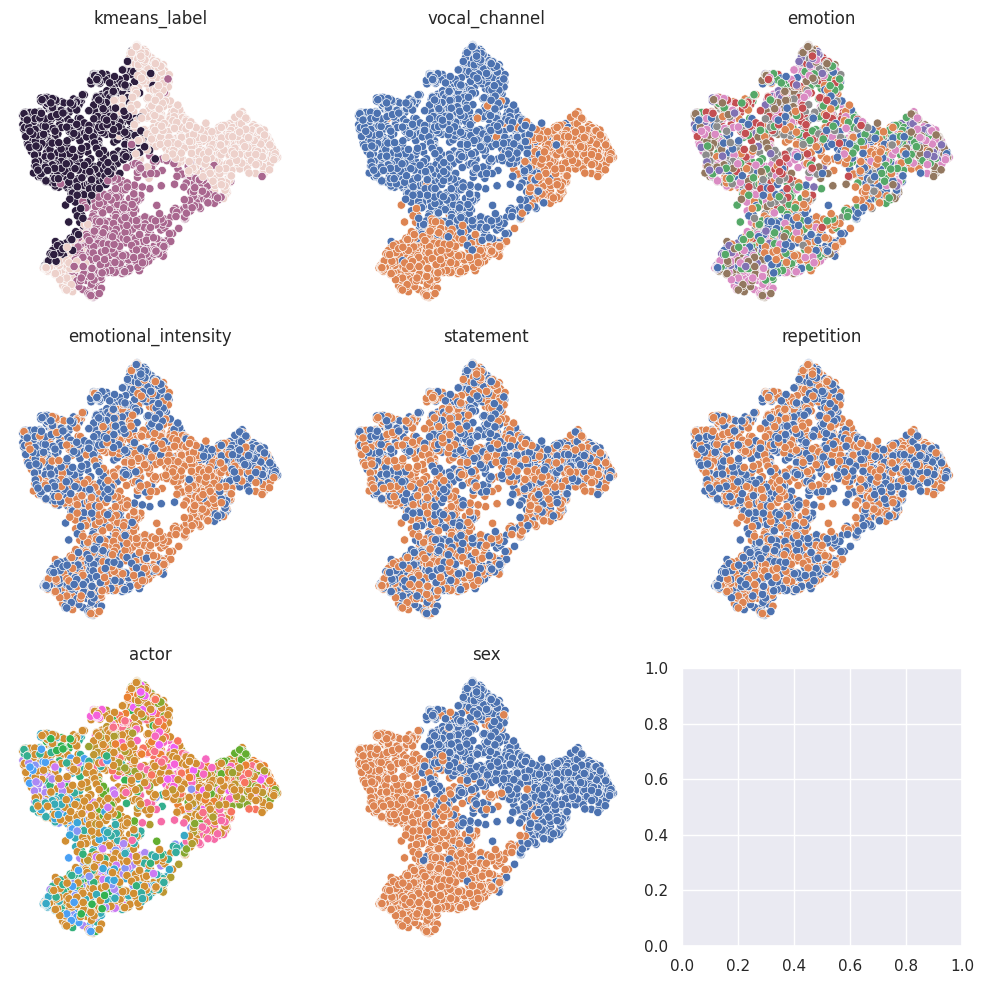

In [10]:
fig, axes = plt.subplots(3,3, figsize=(10,10))
axes = axes.flatten()
for ax, feat in zip(axes, e_df.drop(columns=["x","y","index"]).columns):

    sns.scatterplot(data=e_df, x="x", y="y", hue=feat, ax=ax, legend=False)
    ax.set_title(feat)
    ax.axis("off")

Ricerca valori ottimali

In [71]:
from sklearn.metrics import silhouette_score, mutual_info_score

def mattoplot(cluster_class, X):
    nmeans= range(2, 10)
    nsamp = 10
    silhouettes = np.zeros((len(nmeans),nsamp))

    mi_df = pd.DataFrame(columns=["sex", "vocal_channel", "emotional_intensity", "emotion"])
    sex = []
    vocal_channel = []
    emotional_intensity = []
    emotion = []

    for i, n in enumerate(nmeans):
        for j in range(nsamp):
            kmeans = cluster_class(n_clusters=n, n_init=1)
            kmeans.fit(X)
            silhouettes[i,j] = silhouette_score(X, kmeans.labels_)
            if n == 2:
                sex.append(mutual_info_score(categ.sex, kmeans.labels_))
                vocal_channel.append(mutual_info_score(categ.vocal_channel, kmeans.labels_))
                emotional_intensity.append(mutual_info_score(categ.emotional_intensity, kmeans.labels_))
            if n == 8:
                emotion.append(mutual_info_score(categ.emotion, kmeans.labels_))

    mi_df["sex"] = sex
    mi_df["vocal_channel"] = vocal_channel
    mi_df["emotional_intensity"] = emotional_intensity
    mi_df["emotion"] = emotion

    return mi_df, silhouettes


<AxesSubplot: >

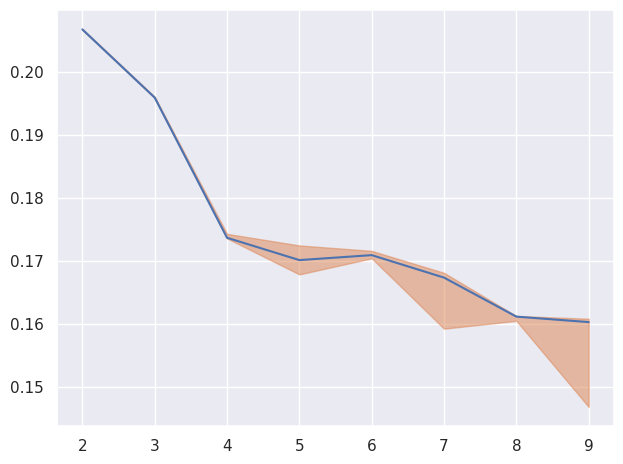

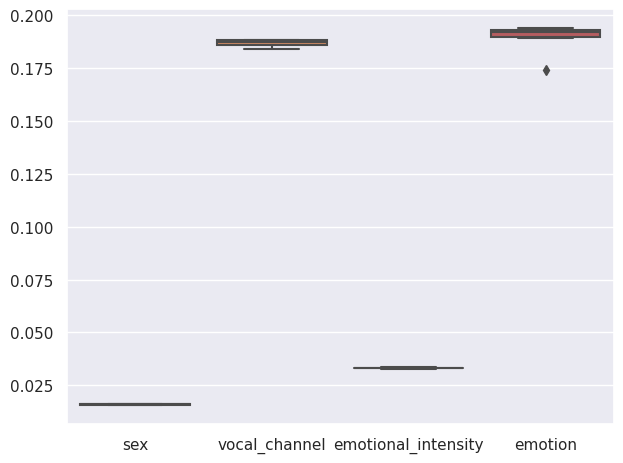

In [76]:
X = MinMaxScaler().fit_transform(quant.values)

mi_df, silhouettes = mattoplot(KMeans,X)
nmeans = range(2,10)
plt.plot(nmeans, np.quantile(silhouettes, 0.5, axis=1))
plt.fill_between(nmeans, * np.quantile(silhouettes, [0.25, 0.75], axis=1), alpha=0.5, color=sns.color_palette()[1])
plt.figure(2)
sns.boxplot(mi_df)

<AxesSubplot: xlabel='x', ylabel='y'>

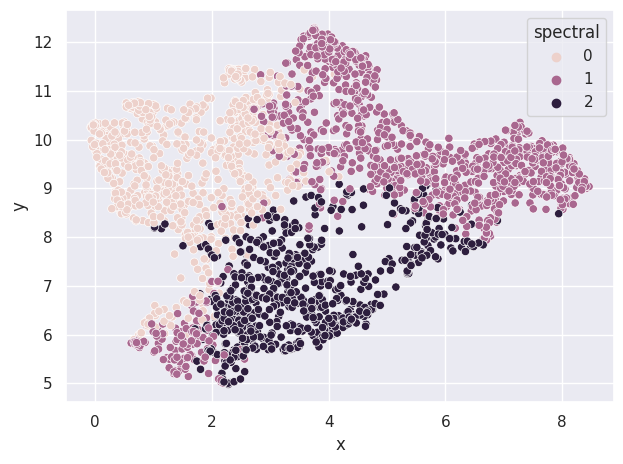

In [12]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=3)
sc.fit(X)
e_df["spectral"] = sc.labels_

sns.scatterplot(data=e_df, x="x", y="y", hue="spectral")

<AxesSubplot: xlabel='stft_min', ylabel='sc_min'>

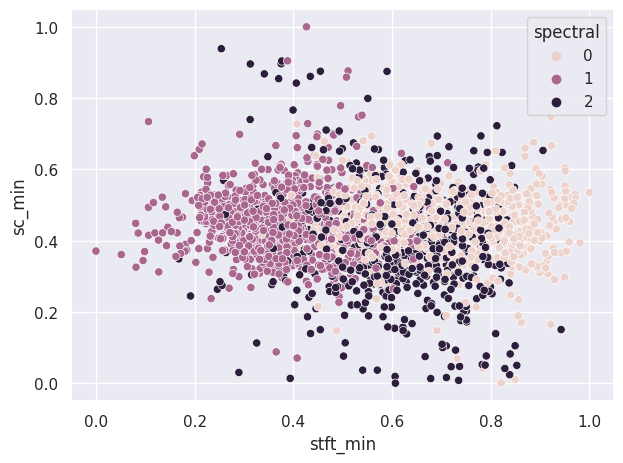

In [13]:
sns.scatterplot(x=quant.stft_min, y=quant.sc_min, hue=e_df["spectral"])